## Challenge: Make Your Network

Create a multi-layer perceptron neural network model to predict on a labeled dataset of your choosing. Compare this model to either a boosted tree or a random forest model and describe the relative tradeoffs between complexity and accuracy. Be sure to vary the hyperparameters of your MLP!

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.neural_network import BernoulliRBM
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
data = pd.read_csv(r'C:\Users\jmfra\OneDrive\Documents\Thinkful Data Science Files\3.6.5 data\breast-cancer-wisconsin.txt', header = None)

In [3]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [4]:
#we dont need the id number
data = data.drop(0, axis=1)

In [5]:
#lets rename the columns from the meta data to more easily identify them
data.columns = ['Clump_Thickness', 'Uniformity_Cell_Size', 'Uniformity_Cell_Shape', 'Marginal_Adhesion', 
              'Single_Epithelial_CellSize', 'Bare_Nuclei', 'Bland_Chromatin', 'Normal_Nucleoli', 
              'Mitoses', 'Class']

In [6]:
#some points in bare nuclei have ? marks
data.loc[data['Bare_Nuclei'] == '?'].describe()

,Clump_Thickness,Uniformity_Cell_Size,Uniformity_Cell_Shape,Marginal_Adhesion,Single_Epithelial_CellSize,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
count,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.0,16.00000
mean,3.375000,2.437500,2.875000,1.812500,2.437500,3.125000,2.750000,1.0,2.25000
std,2.446085,2.365551,2.187083,2.286737,1.672075,1.927866,3.193744,0.0,0.68313
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,2.00000
25%,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.0,2.00000
50%,3.000000,1.000000,2.500000,1.000000,2.000000,2.500000,1.000000,1.0,2.00000
75%,5.000000,4.000000,4.250000,1.000000,2.000000,3.250000,3.000000,1.0,2.00000
max,8.000000,8.000000,8.000000,9.000000,7.000000,7.000000,10.000000,1.0,4.00000


In [7]:
#not enough data to guess why, just delete all rows with ?
data = data.loc[data['Bare_Nuclei'] != '?']
data.head()

,Clump_Thickness,Uniformity_Cell_Size,Uniformity_Cell_Shape,Marginal_Adhesion,Single_Epithelial_CellSize,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
0,5,1,1,1,2,1,3,1,1,2
1,5,4,4,5,7,10,3,2,1,2
2,3,1,1,1,2,2,3,1,1,2
3,6,8,8,1,3,4,3,7,1,2
4,4,1,1,3,2,1,3,1,1,2


In [8]:
#the dependent variable is category 10 (2 for benign, 4 for malignant)
#lets change it to boolean
data['Class'] = np.where(data['Class'] >= 3, 1, 0)

In [9]:
#now we need to change the category with ?
data['Bare_Nuclei'] = data['Bare_Nuclei'].astype('int64')
data.describe()

,Clump_Thickness,Uniformity_Cell_Size,Uniformity_Cell_Shape,Marginal_Adhesion,Single_Epithelial_CellSize,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
count,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000
mean,4.442167,3.150805,3.215227,2.830161,3.234261,3.544656,3.445095,2.869693,1.603221,0.349927
std,2.820761,3.065145,2.988581,2.864562,2.223085,3.643857,2.449697,3.052666,1.732674,0.477297
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,0.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000,1.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000


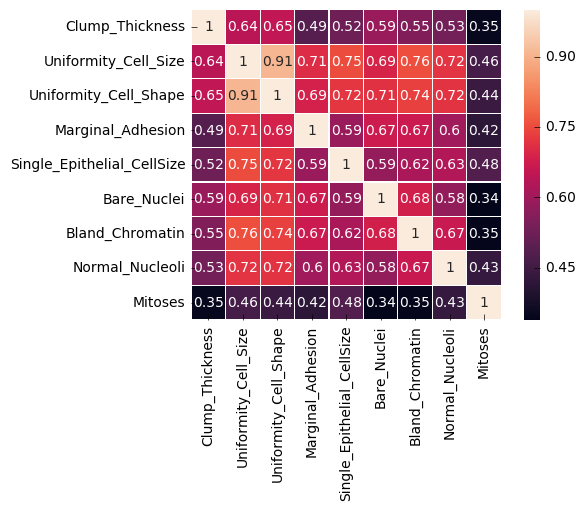

In [10]:
#lets take a look at correlations since all the data seems to be straight forward now
sns.heatmap(data.drop('Class',1).corr(), annot=True, linewidths=.1, square=True)

In [11]:
#cell size and shape are so highly correlated and have almost identical values from the describe function so lets take the average 
#and call it cell uniformity
data['Cell_Uniformity'] = (data['Uniformity_Cell_Size']+data['Uniformity_Cell_Shape'])/2
data = data.drop(['Uniformity_Cell_Size', 'Uniformity_Cell_Shape'], axis=1)

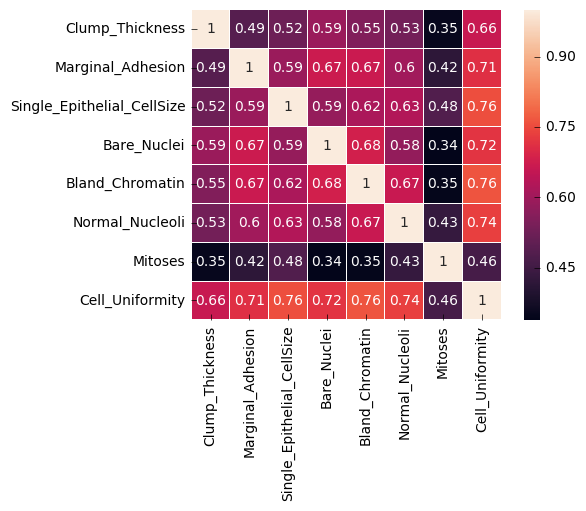

In [12]:
sns.heatmap(data.drop('Class',1).corr(), annot=True, linewidths=.1, square=True)

In [13]:
#The new heat map shows correlations in the 70s but since we are going to use an unsupervised classifier, I am going
#to leave it as is. lets run the random forest to compare our neural network to
X= data.drop('Class',1)
y= data['Class']
rfc = ensemble.RandomForestClassifier(random_state=0)
cross_val_score(rfc, X, y, cv=10).mean()

0.96649489127253752

In [14]:
#lets create a training set to fit on so we can look at the cross tab
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state = 0)

In [15]:
fit = rfc.fit(X_train, y_train)
pred_y_rfc = rfc.predict(X)
crosstab = pd.crosstab(pred_y_rfc, y)
print('Actual on top and predicted on left')
print(crosstab)
print('accurately predicted benign tumour')
print(crosstab.iloc[0,0]/(crosstab.iloc[0,0]+crosstab.iloc[1,0]))
print('accurately predicted dangerous tumour')
print(crosstab.iloc[1,1]/(crosstab.iloc[1,1]+crosstab.iloc[0,1]))

Actual on top and predicted on left
Class    0    1
row_0          
0      438    6
1        6  233
accurately predicted benign tumour
0.986486486486
accurately predicted dangerous tumour
0.97489539749


In [16]:
#the total score is around 98% for the random forest
#lets initialize the nueral network with an increased max iter because trial and
#error showed that some runs wouldnt converge with the default
mlp = MLPClassifier(max_iter=1200)

In [17]:
cross_val_score(mlp, X, y, cv=10).mean()

0.96074168797953985

In [18]:
fit = mlp.fit(X_train, y_train)
pred_y1 = mlp.predict(X)
crosstab = pd.crosstab(pred_y1, y)
print('Actual on top and predicted on left')
print(crosstab)
print('accurately predicted benign tumour')
print(crosstab.iloc[0,0]/(crosstab.iloc[0,0]+crosstab.iloc[1,0]))
print('accurately predicted dangerous tumour')
print(crosstab.iloc[1,1]/(crosstab.iloc[1,1]+crosstab.iloc[0,1]))

Actual on top and predicted on left
Class    0    1
row_0          
0      435   11
1        9  228
accurately predicted benign tumour
0.97972972973
accurately predicted dangerous tumour
0.953974895397


In [19]:
%%time
#the mlp performs worse than the random forest so lets find the best parameters
#going to do one parameter at a time since for some reason, best_params_ wont print all 3
params = {'solver':['lbfgs', 'sgd', 'adam'],
          'alpha':[.00000001,.0000001,.000001,.00001,.0001,.001,.01,.1],
          'hidden_layer_sizes':[(15,),(5,),(10,),(20,),(25,),(30,)]}
svr_opt = GridSearchCV(mlp, params)
svr_opt.fit(X,y)
print(svr_opt.best_params_)

{'hidden_layer_sizes': (5,), 'solver': 'lbfgs', 'alpha': 0.1}
Wall time: 2min 3s


In [20]:
mlp = MLPClassifier(solver='lbfgs', alpha = .1, hidden_layer_sizes=(5,), max_iter=1200)
cross_val_score(mlp, X, y, cv=10).mean()

0.95635123614663264

In [21]:
fit = mlp.fit(X_train, y_train)
pred_y1 = mlp.predict(X)
crosstab = pd.crosstab(pred_y1, y)
print('Actual on top and predicted on left')
print(crosstab)
print('accurately predicted benign tumour')
print(crosstab.iloc[0,0]/(crosstab.iloc[0,0]+crosstab.iloc[1,0]))
print('accurately predicted dangerous tumour')
print(crosstab.iloc[1,1]/(crosstab.iloc[1,1]+crosstab.iloc[0,1]))

Actual on top and predicted on left
Class    0    1
row_0          
0      436    8
1        8  231
accurately predicted benign tumour
0.981981981982
accurately predicted dangerous tumour
0.966527196653


In [22]:
#our model is still worse but only by by 6/699 or .9%
#lets look at the differences
data['RFC_class'] = pred_y_rfc
data['MLP_class'] = pred_y1

In [23]:
data['Mitoses'][data['MLP_class'] == data['RFC_class']].count()

671

In [24]:
data['Mitoses'][data['MLP_class'] != data['RFC_class']].count()

12

In [25]:
data[data['MLP_class'] != data['RFC_class']]

,Clump_Thickness,Marginal_Adhesion,Single_Epithelial_CellSize,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class,Cell_Uniformity,RFC_class,MLP_class
3,6,1,3,4,3,7,1,0,8.0,0,1
51,5,4,2,4,3,4,1,1,3.0,1,0
101,2,4,2,5,2,5,1,1,3.5,1,0
103,8,1,6,3,7,1,1,1,2.5,0,1
196,8,5,4,7,7,8,2,0,4.0,0,1
222,4,3,1,5,2,1,1,1,1.0,1,0
252,6,5,3,10,3,5,3,0,3.0,0,1
319,4,4,6,5,7,3,1,0,4.0,0,1
326,10,1,2,10,5,4,1,1,1.0,0,1
352,3,3,7,3,4,6,1,0,4.5,1,0


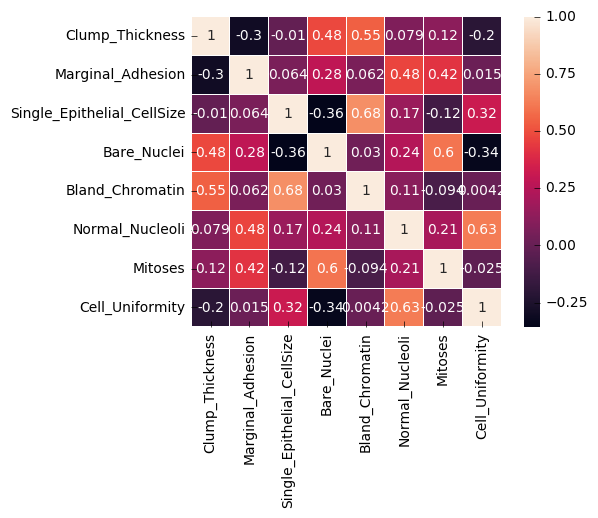

In [26]:
sns.heatmap(data[data['MLP_class'] != data['RFC_class']].drop(['Class', 'RFC_class', 'MLP_class'],1).corr(), annot=True, linewidths=.1, square=True)

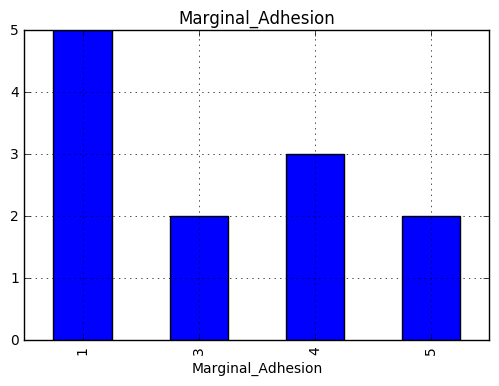

In [27]:
data[data['MLP_class'] != data['RFC_class']].groupby('Marginal_Adhesion')['Clump_Thickness'].count().plot.bar(title='Marginal_Adhesion', grid=True)
plt.show()

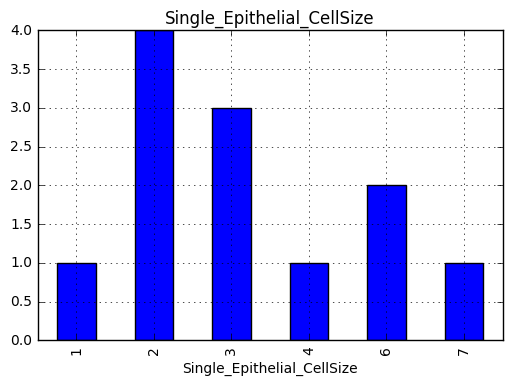

In [28]:
data[data['MLP_class'] != data['RFC_class']].groupby('Single_Epithelial_CellSize')['Single_Epithelial_CellSize'].count().plot.bar(title='Single_Epithelial_CellSize', grid=True)
plt.show()

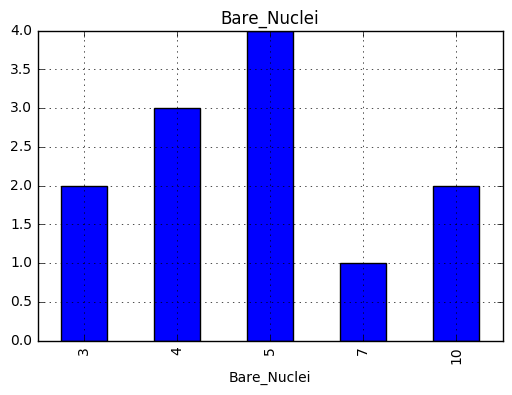

In [29]:
data[data['MLP_class'] != data['RFC_class']].groupby('Bare_Nuclei')['Single_Epithelial_CellSize'].count().plot.bar(title='Bare_Nuclei', grid=True)
plt.show()

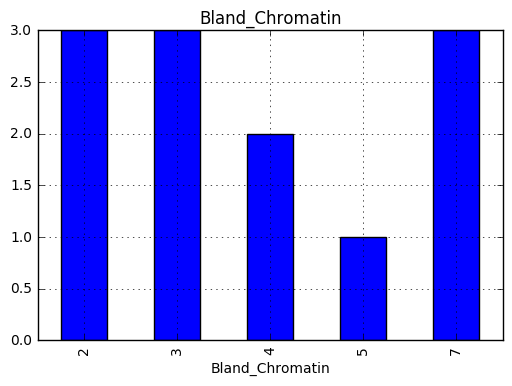

In [30]:
data[data['MLP_class'] != data['RFC_class']].groupby('Bland_Chromatin')['Single_Epithelial_CellSize'].count().plot.bar(title='Bland_Chromatin', grid=True)
plt.show()

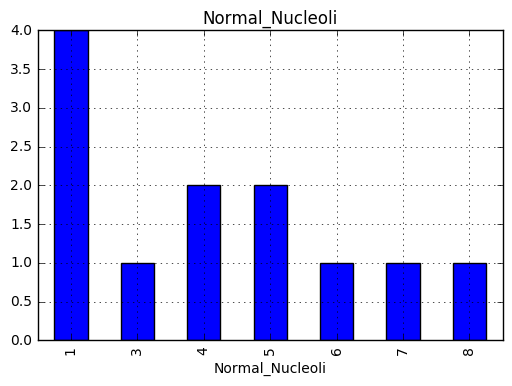

In [31]:
data[data['MLP_class'] != data['RFC_class']].groupby('Normal_Nucleoli')['Single_Epithelial_CellSize'].count().plot.bar(title='Normal_Nucleoli', grid=True)
plt.show()

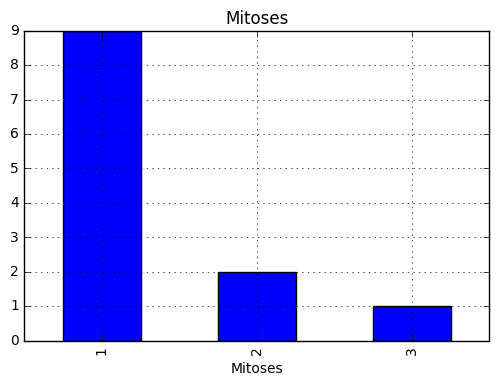

In [32]:
data[data['MLP_class'] != data['RFC_class']].groupby('Mitoses')['Single_Epithelial_CellSize'].count().plot.bar(title='Mitoses', grid=True)
plt.show()

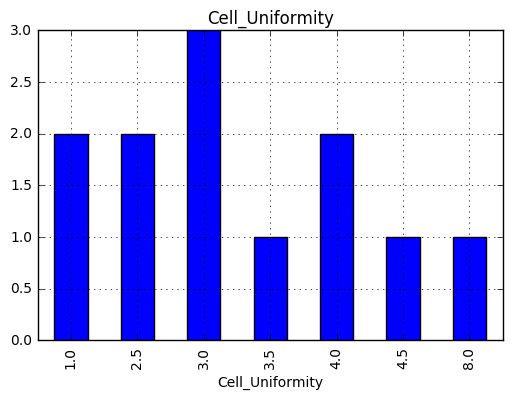

In [33]:
data[data['MLP_class'] != data['RFC_class']].groupby('Cell_Uniformity')['Single_Epithelial_CellSize'].count().plot.bar(title='Cell_Uniformity', grid=True)
plt.show()